In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

subnums = np.arange(32, 98, 1)
subject_numbers = np.delete(subnums, np.where((subnums == 37) | (subnums == 66) | (subnums == 68) | (subnums == 78) | (subnums == 84) | (subnums == 90) | (subnums == 94) | (subnums == 96)))
frontal_midline_channels = ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']

# Initialize dictionaries to store lists of correlations and temporal shifts per electrode across subjects
electrode_correlation_values = {channel: [] for channel in frontal_midline_channels}
electrode_temporal_shifts = {channel: [] for channel in frontal_midline_channels}

for subject_number in subject_numbers:
    # Load and normalize pupil data
    pupil_data = pd.read_csv(f"Pupil_Processed/pupil_memory_sub-0{subject_number}.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])
    pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
    mean_diameters = pupil_data['Mean_Diameter_Normalized']

    for electrode in frontal_midline_channels:
        # Load theta data for the current electrode and subject
        theta_data = pd.read_csv(f"Theta_Processed/theta_results_subject_0{subject_number}.csv", usecols=['Time', f'Theta_Power_Memory_{electrode}', f'SEM_Memory_{electrode}'])
        theta_data[f'Theta_Power_Memory_{electrode}'] = pd.to_numeric(theta_data[f'Theta_Power_Memory_{electrode}'], errors='coerce')

        # Resample theta data by averaging every 10 rows
        theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
        
        # Normalize the theta power columns
        theta_resampled['Theta_Power_Memory_Normalized'] = (theta_resampled[f'Theta_Power_Memory_{electrode}'] - theta_resampled[f'Theta_Power_Memory_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Memory_{electrode}'].std()
        power = theta_resampled['Theta_Power_Memory_Normalized']

        # Valid time indices for the 0 to 8 seconds range (200 to 1100 in pupil data)
        valid_start_index = 200
        valid_end_index = 1100
        temporal_shifts_samples = np.arange(-100, 101, 1)

        # Initialize variables for best results for this electrode and subject
        best_correlation = -np.inf
        best_temporal_shift = None

        # Loop through temporal shifts and calculate correlations
        for shift_samples in temporal_shifts_samples:
            power_shifted = np.roll(power, shift_samples)
            mean_diameters_window = mean_diameters[valid_start_index:valid_end_index]
            power_shifted_window = power_shifted[valid_start_index:valid_end_index]

            # Calculate the correlation coefficient
            correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]

            # Update the best parameters if the current correlation is the highest
            if correlation > best_correlation:
                best_correlation = correlation
                best_temporal_shift = shift_samples * 10  # Convert to milliseconds

        # Append best correlation and temporal shift to respective lists
        electrode_correlation_values[electrode].append(best_correlation)
        electrode_temporal_shifts[electrode].append(best_temporal_shift)

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Electrode': frontal_midline_channels,
    'Mean Correlation': [np.mean(electrode_correlation_values[ch]) for ch in frontal_midline_channels],
    'SEM Correlation': [(np.std(electrode_correlation_values[ch]) / np.sqrt(len(electrode_correlation_values[ch]))) for ch in frontal_midline_channels],
    'Mean Temporal Shift (ms)': [np.mean(electrode_temporal_shifts[ch]) for ch in frontal_midline_channels],
    'SEM Temporal Shift (ms)': [(np.std(electrode_temporal_shifts[ch]) / np.sqrt(len(electrode_temporal_shifts[ch]))) for ch in frontal_midline_channels]
})

# Print the DataFrame
print("\nSummary of Mean Correlation and Temporal Shifts for each Electrode:")
results_df.sort_values('Mean Correlation', ascending=False).round(3)



Summary of Mean Correlation and Temporal Shifts for each Electrode:


,Electrode,Mean Correlation,SEM Correlation,Mean Temporal Shift (ms),SEM Temporal Shift (ms)
0,AFz,0.294,0.033,231.379,62.684
5,F2,0.288,0.037,278.448,73.931
2,AF4,0.288,0.033,220.000,61.036
1,AF3,0.283,0.032,248.793,62.120
7,F4,0.282,0.034,160.862,75.169
4,F1,0.277,0.037,284.138,73.604
3,Fz,0.276,0.037,295.345,74.506
16,C4,0.264,0.037,95.000,88.668
13,C3,0.260,0.035,128.448,84.277
9,FC1,0.255,0.030,179.483,94.845


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

subnums = np.arange(32, 98, 1)
subject_numbers = np.delete(subnums, np.where((subnums == 37) | (subnums == 66) | (subnums == 68) | (subnums == 78) | (subnums == 84) | (subnums == 90) | (subnums == 94) | (subnums == 96)))
# subject_numbers = [32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71]
frontal_midline_channels = ['AFz', 'AF3', 'AF4', 'Fz', 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']

# Initialize dictionaries to store lists of correlations and temporal shifts per electrode across subjects
electrode_correlation_values_control = {channel: [] for channel in frontal_midline_channels}
electrode_temporal_shifts_control = {channel: [] for channel in frontal_midline_channels}

for index, subject_number in enumerate(subject_numbers):
    # Load pupil data
    pupil_data = pd.read_csv(f"Pupil_Processed/pupil_control_sub-0{subject_number}.csv", usecols=['Mean_Diameter', 'SEM_Diameter'])

    # Normalize pupil data
    pupil_data['Mean_Diameter_Normalized'] = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
    pupil_data['SEM_Diameter_Normalized'] = pupil_data['SEM_Diameter'] / pupil_data['Mean_Diameter'].std()

    mean_diameters = pupil_data['Mean_Diameter_Normalized']

    for electrode in frontal_midline_channels:
        # Load theta data for the current electrode
        theta_data = pd.read_csv(f"Theta_Processed/theta_results_subject_0{subject_number}.csv", usecols=['Time', f'Theta_Power_Control_{electrode}', f'SEM_Control_{electrode}'])
        theta_data[f'Theta_Power_Control_{electrode}'] = pd.to_numeric(theta_data[f'Theta_Power_Control_{electrode}'], errors='coerce')
        
        # Drop the "Time" column since it's not needed for resampling
        theta_data = theta_data.drop(columns=['Time'])

        # Resample the theta data by averaging every 10 rows
        theta_resampled = theta_data.groupby(np.arange(len(theta_data)) // 10).mean().reset_index(drop=True)
        theta_resampled['Index'] = np.arange(len(theta_resampled)) * 10  # Every 10 ms
        theta_resampled = theta_resampled[['Index', f'Theta_Power_Control_{electrode}', f'SEM_Control_{electrode}']]

        # Normalize theta power data
        theta_resampled['Theta_Power_Control_Normalized'] = (theta_resampled[f'Theta_Power_Control_{electrode}'] - theta_resampled[f'Theta_Power_Control_{electrode}'].mean()) / theta_resampled[f'Theta_Power_Control_{electrode}'].std()
        theta_resampled['SEM_Power_Control_Normalized'] = theta_resampled[f'SEM_Control_{electrode}'] / theta_resampled[f'Theta_Power_Control_{electrode}'].std()

        power = theta_resampled['Theta_Power_Control_Normalized']

        # Define the valid time indices for the 0 to 8 seconds range (200 to 1100 in pupil data)
        valid_start_index = 200  # Corresponds to 0 seconds
        valid_end_index = 1100   # Corresponds to 8 seconds (exclusive)

        # Define the range of temporal shifts (-100 to +100 samples)
        temporal_shifts_samples = np.arange(-100, 101, 1)  # Shifting by ±100 samples

        # Initialize variables to store the best results for this electrode and subject
        best_correlation = -np.inf
        best_temporal_shift = None

        mean_diameters_smoothed = mean_diameters  # savgol_filter(mean_diameters, window_length, polyorder)
        power_smoothed = power  # savgol_filter(power, window_length, polyorder)

        for shift_samples in temporal_shifts_samples:
            power_shifted = np.roll(power_smoothed, shift_samples)

            # Extract the fixed 200-1100 window from both smoothed arrays
            mean_diameters_window = mean_diameters_smoothed[valid_start_index:valid_end_index]
            power_shifted_window = power_shifted[valid_start_index:valid_end_index]

            # Calculate the correlation coefficient
            correlation = np.corrcoef(mean_diameters_window, power_shifted_window)[0, 1]

            # Update the best parameters if the current correlation is the highest
            if correlation > best_correlation:
                best_correlation = correlation
                best_temporal_shift = shift_samples * 10  # Convert to milliseconds
                
        # Append best correlation and temporal shift to respective lists
        electrode_correlation_values_control[electrode].append(best_correlation)
        electrode_temporal_shifts_control[electrode].append(best_temporal_shift)
        
# Create a DataFrame to summarize control results
results_df_control = pd.DataFrame({
    'Electrode': frontal_midline_channels,
    'Mean Correlation (Control)': [np.mean(electrode_correlation_values_control[ch]) for ch in frontal_midline_channels],
    'SEM Correlation (Control)': [(np.std(electrode_correlation_values_control[ch]) / np.sqrt(len(electrode_correlation_values_control[ch]))) for ch in frontal_midline_channels],
    'Mean Temporal Shift (ms) (Control)': [np.mean(electrode_temporal_shifts_control[ch]) for ch in frontal_midline_channels],
    'SEM Temporal Shift (ms) (Control)': [(np.std(electrode_temporal_shifts_control[ch]) / np.sqrt(len(electrode_temporal_shifts_control[ch]))) for ch in frontal_midline_channels]
})

results_df_control.sort_values('Mean Correlation (Control)', ascending=False).round(3)


,Electrode,Mean Correlation (Control),SEM Correlation (Control),Mean Temporal Shift (ms) (Control),SEM Temporal Shift (ms) (Control)
0,AFz,0.235,0.025,-46.897,86.913
1,AF3,0.233,0.025,30.517,87.786
2,AF4,0.229,0.025,22.241,87.142
15,C2,0.228,0.022,316.897,87.422
4,F1,0.226,0.027,186.034,88.493
14,C1,0.225,0.024,125.517,93.648
6,F3,0.222,0.027,219.828,95.106
8,FC3,0.215,0.027,189.310,100.697
16,C4,0.214,0.026,223.103,81.322
13,C3,0.214,0.026,124.828,86.647


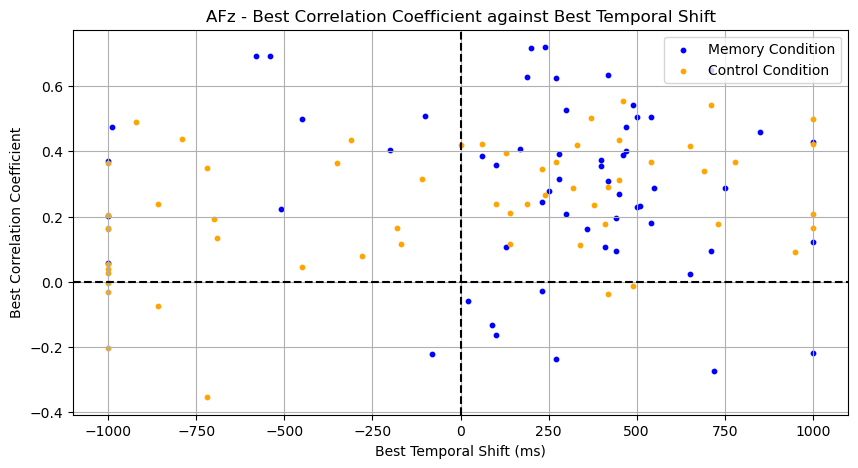

In [3]:
electrode = 'AFz'

# Extract best correlations and best temporal shifts for the AFz electrode
best_correlations_AFz = electrode_correlation_values[electrode]
best_temporal_shifts_AFz = electrode_temporal_shifts[electrode]

best_correlations_AFz_control = electrode_correlation_values_control[electrode]
best_temporal_shifts_AFz_control = electrode_temporal_shifts_control[electrode]

# Plot the best correlations against the best temporal shifts for AFz electrode
plt.figure(figsize=(10, 5))
plt.scatter(best_temporal_shifts_AFz, best_correlations_AFz, marker='o', s=10, color='b', label='Memory Condition')
plt.scatter(best_temporal_shifts_AFz_control, best_correlations_AFz_control, marker='o', s=10, color='orange', label='Control Condition')
plt.xticks(np.arange(-1000, 1001, 250))
plt.xlabel('Best Temporal Shift (ms)')
plt.ylabel('Best Correlation Coefficient')
plt.title(f'{electrode} - Best Correlation Coefficient against Best Temporal Shift')
plt.grid(True)
plt.axhline(0, color='k', linestyle='--')  # Optional: horizontal line at y=0 for reference
plt.axvline(0, color='k', linestyle='--')  # Optional: vertical line at x=0 for reference
plt.legend()
plt.show()
